In [1]:
library(rethinking)
library(tidyverse)
library(ggplot2)

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: parallel

Loading required package: dagitty

rethinking (Version 1.95)


Attaching package: ‘rethinking’


The following object is masked from ‘package:stats’:

    rstudent


─ Attaching packages ──────────────────── tidyverse 1.3.0 ─

✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.3     

─ Conflicts ───────────────────── tidyverse_conflicts() ─
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ purrr::map()     masks rethinking::map()



# 后验分布的网格近似

In [3]:
d <-
tibble(p_grid     = seq(from = 0, to = 1, length.out = 1000),
     # 使用1为均匀先验
     prior      = 1) %>% 
mutate(likelihood = dbinom(6, size = 9, prob = p_grid)) %>% 
mutate(posterior  = (likelihood * prior) / sum(likelihood * prior))
head(d)

p_grid,prior,likelihood,posterior
<dbl>,<dbl>,<dbl>,<dbl>
0.000000000,1,0.000000e+00,0.000000e+00
0.001001001,1,8.425225e-17,8.433659e-19
0.002002002,1,5.375951e-15,5.381333e-17
0.003003003,1,6.105137e-14,6.111249e-16
0.004004004,1,3.419945e-13,3.423368e-15
0.005005005,1,1.300676e-12,1.301978e-14


sample_n(moviedata,10)：随机无重复的取10行数据  
sample_n(moviedata,20,replace=TRUE)：随机有重复的取20行数据  
sample_n(moviedata,10,weight = imdb_score)：随机无重复的以imdb_score做权重取10行数据  
sample_frac(moviedata,0.01)：随机无重复的取1%的数据  
sample_frac(moviedata,1.3,replace=TRUE)：随机有重复的取总行数的1.3倍的数据  

sample_n(tbl, size, replace = FALSE, weight = NULL, .env = NULL, ...)  
sample_frac(tbl, size = 1, replace = FALSE, weight = NULL,
  .env = NULL, ...)  
- 可以使用`sample_n()`和`sample_frac()`获得一个行的随机样本。使用`sample_n()`可选择固定的行数，`sample_frac()`可选择占总行数固定比例的行数。
- 输入数据是tbl格式，size表示抽取的个数，replace指的是能否重复抽取，weight指的是抽取比重

In [10]:
set.seed(3)
t1<-Sys.time()
samples <-
  d %>% 
  sample_n(size = 1e5, weight = posterior, replace = T)

glimpse(samples)
Sys.time() - t1

Observations: 100,000
Variables: 4
$ p_grid     <dbl> 0.5645646, 0.6516517, 0.5475475, 0.5905906, 0.5955956, 0.…
$ prior      <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ likelihood <dbl> 0.22455994, 0.27190272, 0.20966655, 0.24460869, 0.2479909…
$ posterior  <dbl> 0.0022478473, 0.0027217490, 0.0020987643, 0.0024485355, 0…


Time difference of 0.01514006 secs

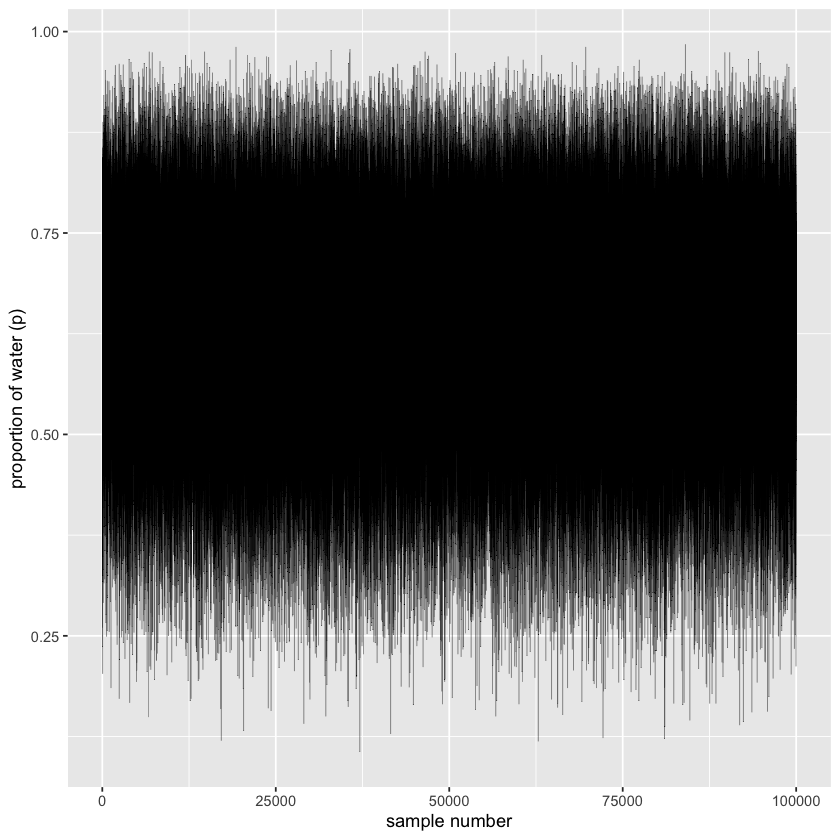

Time difference of 2.272734 secs

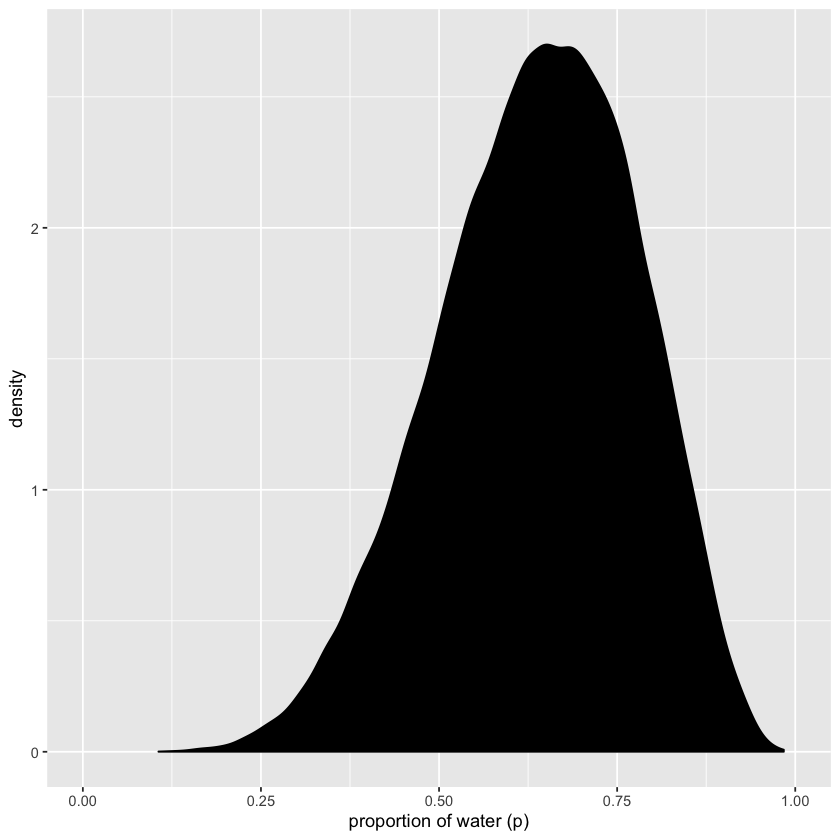

In [11]:
t1<-Sys.time()
samples %>%
    mutate(sample_number = 1:n()) %>% 

ggplot(aes(x = sample_number, y = p_grid)) +
  geom_line(size = 1/10) +
  labs(x = "sample number",
       y = "proportion of water (p)")

samples %>% ggplot(aes(x = p_grid)) +
  geom_density(fill = "black") +
  coord_cartesian(xlim = 0:1) +
  xlab("proportion of water (p)")
Sys.time() - t1

## 获取分位点对应置信度

In [77]:
# 将 P <0.5 的后验概率相加
print(sum(posterior[p_grid < 0.5]))
d %>% filter(p_grid < .5) %>% summarise(sum = sum(posterior))

[1] 0.1718746


sum
<dbl>
0.1718746


In [63]:
# 获取0.65-0.75之间的后验
samples %>% 
  filter(p_grid > .5 & p_grid < .75) %>% 
  summarise(sum = n() / 1e5)

sum
<dbl>
0.60451


## 获取累积置信度

In [118]:
quantile(samples$p_grid, prob = .8)

80% 
0.7607608

In [99]:
samples %>% 
  select(p_grid) %>% 
  pull() %>% 
  quantile(prob = .8)

80% 
0.7607608

In [100]:
samples %>% 
  summarise(`80th percentile` = quantile(p_grid, p = .8))

80th percentile
<dbl>
0.7607608


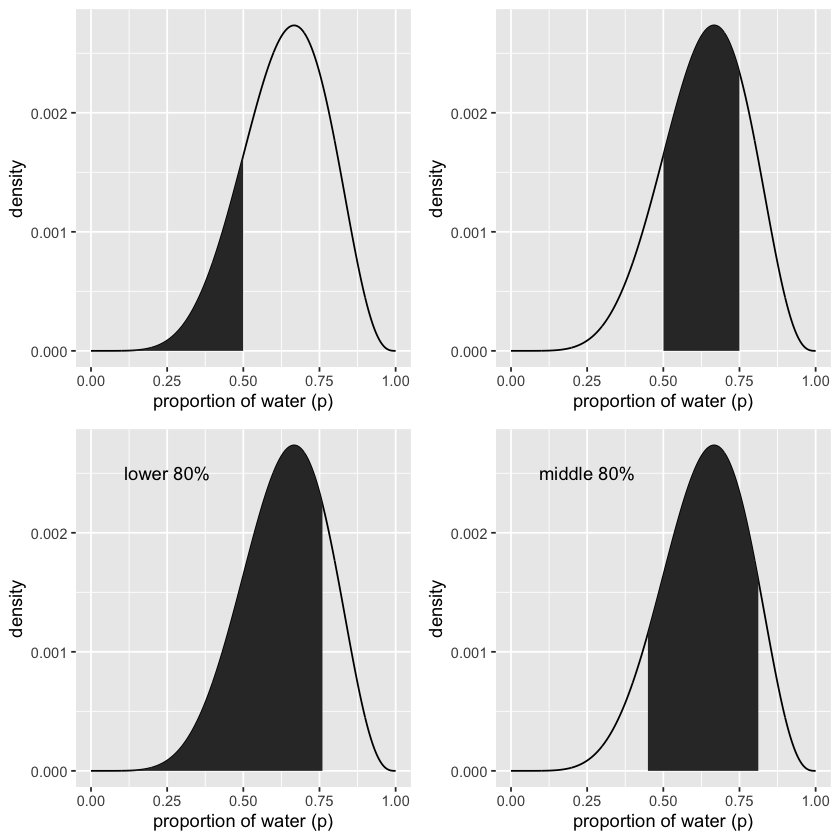

In [115]:
p1 = ggplot(d, aes(x = p_grid)) +
  geom_line(aes(y = posterior)) +
  geom_ribbon(data = d %>% filter(p_grid < .5),
              aes(ymin = 0, ymax = posterior)) +
  labs(x = "proportion of water (p)",
       y = "density")

p2 = ggplot(d, aes(x = p_grid)) +
  geom_line(aes(y = posterior)) +
  geom_ribbon(data = d %>% filter(p_grid < .75 & p_grid > .5),   # 唯一不同之处
              aes(ymin = 0, ymax = posterior)) +
  labs(x = "proportion of water (p)",
       y = "density")

p3 = ggplot(d, aes(x = p_grid)) +
  geom_line(aes(y = posterior)) +
  geom_ribbon(data = d %>% filter(p_grid < quantile(samples$p_grid, prob = .8)),
              aes(ymin = 0, ymax = posterior)) +
  annotate(geom = "text",
           x = .25, y = .0025,
           label = "lower 80%") +
  labs(x = "proportion of water (p)",
       y = "density")

q_10_and_90 <- quantile(samples$p_grid, prob = c(.1, .9))

p4 = ggplot(d, aes(x = p_grid)) +
  geom_line(aes(y = posterior)) +
  geom_ribbon(data = d %>% filter(p_grid > q_10_and_90[1] & p_grid < q_10_and_90[2]),
              aes(ymin = 0, ymax = posterior)) +
  annotate(geom = "text",
           x = .25, y = .0025,
           label = "middle 80%") +
  labs(x = "proportion of water (p)",
       y = "density")

cowplot::plot_grid(p1, p2, p3, p4, nrow = 2, ncol = 2)

## 获取累积置信区间

In [150]:
n_success <- 3
n_trials  <- 3

# update `d`
d <-
  d %>% 
  mutate(likelihood = dbinom(n_success, size = n_trials, prob = p_grid)) %>% 
  mutate(posterior  = (likelihood * prior) / sum(posterior))

# make the next part reproducible
set.seed(3)

# here's our new samples tibble
samples <-
    d %>% 
    sample_n(size = 1e5, weight = posterior, replace = T)
head(samples)

p_grid,prior,likelihood,posterior
<dbl>,<dbl>,<dbl>,<dbl>
0.7167167,1,0.3681651,0.3681651
0.6516517,1,0.2767238,0.2767238
0.5475475,1,0.1641593,0.1641593
1.0000000,1,1.0000000,1.0000000
0.9909910,1,0.9732157,0.9732157
0.7877878,1,0.4889087,0.4889087


In [61]:
quantile(samples$p_grid, prob = c(.1, .9))

10%       90% 
0.5645646 0.9739740

In [62]:
rethinking::PI(samples$p_grid, prob = .5)

25%       75% 
0.7077077 0.9319319

In [63]:
HPDI(samples$p_grid, prob = .5)   #50%的最高后验密度区间，即取值分布最密集的区间

|0.5      0.5| 
0.8418418 1.0000000

In [64]:
library(tidybayes)
mode_hdi(samples$p_grid, .width = .5)
qi(samples$p_grid, .width = .5)
hdi(samples$p_grid, .width = .5)

y,ymin,ymax,.width,.point,.interval
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.9674931,0.8418418,1,0.5,mode,hdi


0.7077077,0.9319319


0.8418418,1


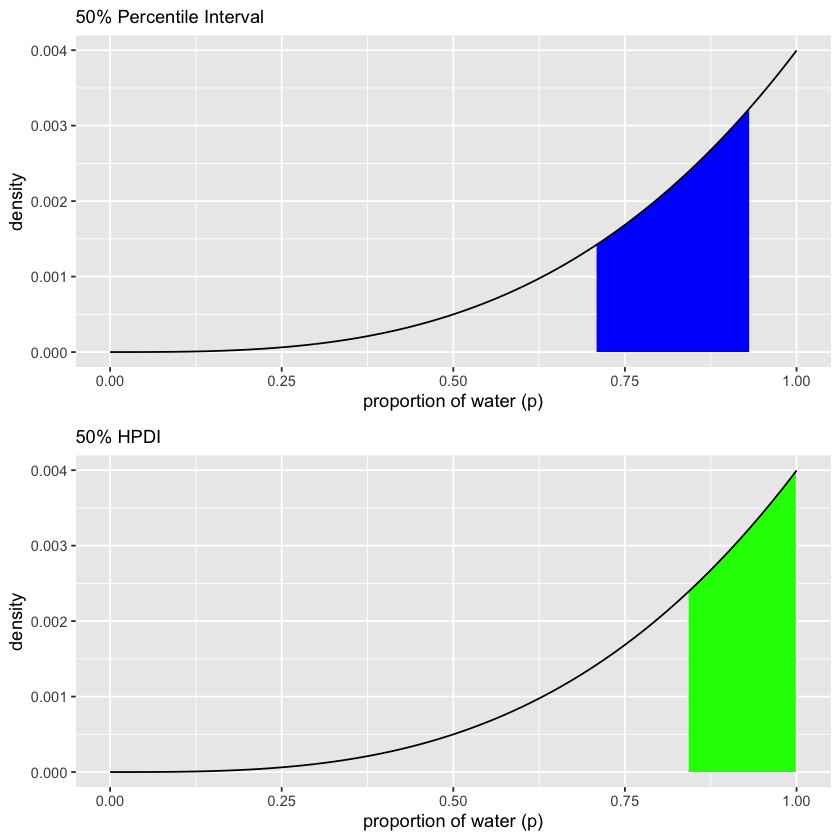

In [65]:
p5 = ggplot(d, aes(x = p_grid)) +
  # check out our sweet `qi()` indexing
  geom_ribbon(data = d %>% filter(p_grid > qi(samples$p_grid, .width = .5)[1] & 
                                    p_grid < qi(samples$p_grid, .width = .5)[2]),
              aes(ymin = 0, ymax = posterior),
              fill = "blue") +
  geom_line(aes(y = posterior)) +
  labs(subtitle = "50% Percentile Interval",
       x = "proportion of water (p)",
       y = "density")
p6 = ggplot(d, aes(x = p_grid)) +
  geom_ribbon(data = d %>% filter(p_grid > hdi(samples$p_grid, .width = .5)[1] & 
                                    p_grid < hdi(samples$p_grid, .width = .5)[2]),
              aes(ymin = 0, ymax = posterior),
              fill = "green") +
  geom_line(aes(y = posterior)) +
  labs(subtitle = "50% HPDI",
       x = "proportion of water (p)",
       y = "density")

cowplot::plot_grid(p5, p6, nrow = 2)

## 点估计

In [66]:
head(arrange(d, desc(posterior)))   #按后验降序排列

p_grid,prior,likelihood,posterior
<dbl>,<dbl>,<dbl>,<dbl>
1.000000,1,1.000000,0.003996000
0.998999,1,0.997000,0.003984012
0.997998,1,0.994006,0.003972048
0.996997,1,0.991018,0.003960108
0.995996,1,0.988036,0.003948192
0.994995,1,0.985060,0.003936300


In [81]:
samples$p_grid[ which.max(samples$posterior) ]    #获取最大后验

[1] 1

In [95]:
d %>% 
  select(posterior) %>% 
  top_n(n = 1)

Selecting by posterior



posterior
<dbl>
0.003996


In [67]:
arrange(d, desc(posterior)) %>% slice(1)   

p_grid,prior,likelihood,posterior
<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0.003996


使用来自后验分布的样本来逼近相同的统计量

In [97]:
chainmode(samples$p_grid, adj=0.01 )

[1] 0.9893706

In [98]:
library(tidybayes)
samples %>% mode_hdi(p_grid)
samples %>% mode_qi(p_grid)

p_grid,.lower,.upper,.width,.point,.interval
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.9674931,0.4734735,1,0.95,mode,hdi


p_grid,.lower,.upper,.width,.point,.interval
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.9674931,0.3973974,0.993994,0.95,mode,qi


In [77]:
Mode(samples$p_grid)  #tidybayes

[1] 0.9674931

## 均值和中位数

In [74]:
samples %>% 
  summarise(mean   = mean(p_grid),
            median = median(p_grid))

mean,median
<dbl>,<dbl>
0.8009566,0.8418418


In [105]:
round(mean(samples$p_grid), 3)
round(median(samples$p_grid), 3)

[1] 0.801

[1] 0.842

三种类型的点估计

In [84]:
point_estimates <-
  bind_rows(
    samples %>% mean_qi(p_grid),    #tidybayes
    samples %>% median_qi(p_grid),  #tidybayes
    samples %>% mode_qi(p_grid)     #tidybayes
  ) %>% 
  select(p_grid, .point) %>% 
  # these last two columns will help us annotate  
  mutate(x = p_grid + c(-.03, .03, -.03),
         y = c(.1, .25, .4))
point_estimates

p_grid,.point,x,y
<dbl>,<chr>,<dbl>,<dbl>
0.8009566,mean,0.7709566,0.10
0.8418418,median,0.8718418,0.25
0.9674931,mode,0.9374931,0.40


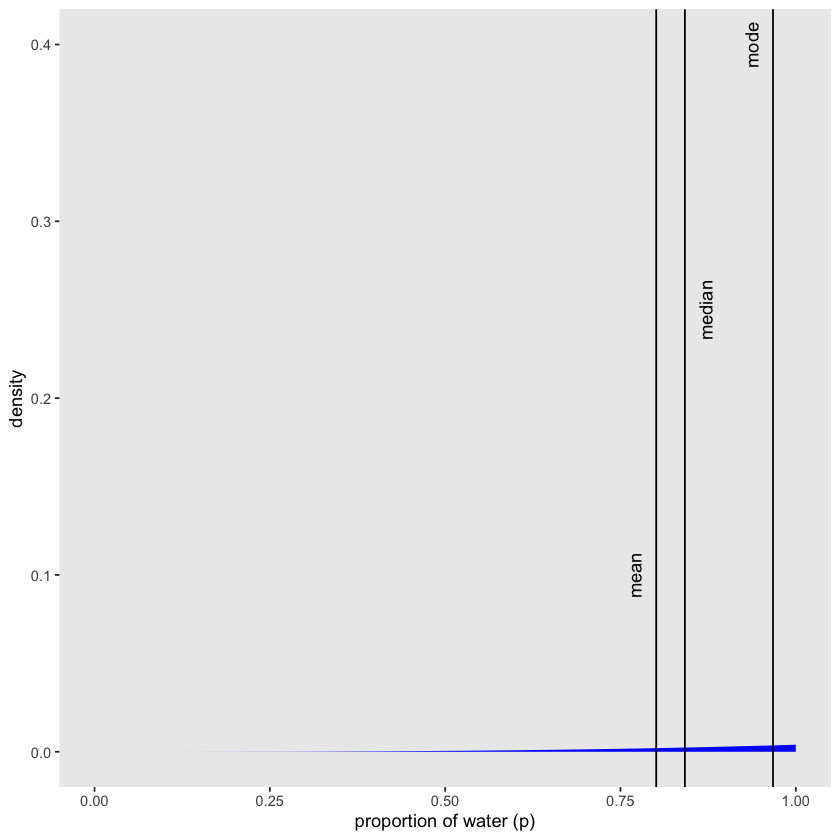

In [93]:
d %>% 
  ggplot(aes(x = p_grid)) +
  geom_ribbon(aes(ymin = 0, ymax = posterior),
              fill = "blue") +
  geom_vline(xintercept = point_estimates$p_grid) +
  geom_text(data = point_estimates,
            aes(x = x, y = y, label = .point),
            angle = 90) +
  labs(x = "proportion of water (p)",
       y = "density") +
  theme(panel.grid = element_blank())

## 损失函数

In [170]:
d %>% 
  mutate(loss = posterior * abs(0.5 - p_grid)) %>% 
  summarise(`expected loss` = sum(loss))

expected loss
<dbl>
78.29709


In [129]:
sum(d$posterior*abs( 0.5 - d$p_grid)) # p = .5 时的离差损失期望

[1] 0.3128752

上面代码所做的就是计算加权平均损失。其中，用相应的后验概率对损失进行加权。 

In [126]:
loss <- 
sapply(d$p_grid , function(k) sum(d$posterior*abs(k - d$p_grid)))
       
d$p_grid[which.min(loss)]

[1] 0.8408408

最小化损失期望的估计值(采用离差评估损失)，即后验中位数

In [175]:
make_loss <- function(our_d){
  d %>% 
  mutate(loss = posterior * abs(our_d - p_grid)) %>% 
  summarise(weighted_average_loss = sum(loss))
}

l <-
  d %>% 
  select(p_grid) %>% 
  rename(decision = p_grid) %>% 
  mutate(weighted_average_loss = purrr::map(decision, make_loss)) %>% 
  unnest() 
head(l)
min(l$weighted_average_loss)

Warning message:
“`cols` is now required.
Please use `cols = c(weighted_average_loss)`”


decision,weighted_average_loss
<dbl>,<dbl>
0.000000000,200.3003
0.001001001,200.0498
0.002002002,199.7993
0.003003003,199.5488
0.004004004,199.2983
0.005005005,199.0478


[1] 31.8685

### 基于离差的损失函数

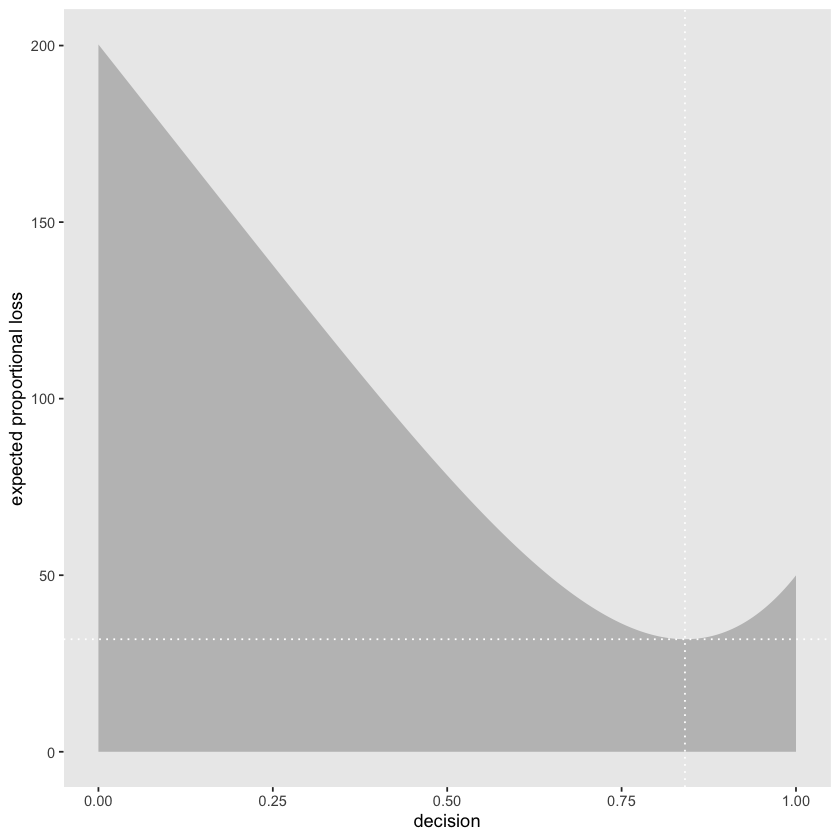

In [173]:
min_loss <-
  l %>% 
  filter(weighted_average_loss == min(weighted_average_loss)) %>% 
  as.numeric()

# the plot
l %>%   
  ggplot(aes(x = decision)) +
  geom_ribbon(aes(ymin = 0, ymax = weighted_average_loss),
              fill = "grey75") +
  geom_vline(xintercept = min_loss[1], color = "white", linetype = 3) +
  geom_hline(yintercept = min_loss[2], color = "white", linetype = 3) +
  ylab("expected proportional loss") +
  theme(panel.grid = element_blank())

In [166]:
samples %>% 
  summarise(posterior_median = median(p_grid))

posterior_median
<dbl>
0.9149149


### 基于离差均方的损失函数

Warning message:
“`cols` is now required.
Please use `cols = c(weighted_average_loss)`”


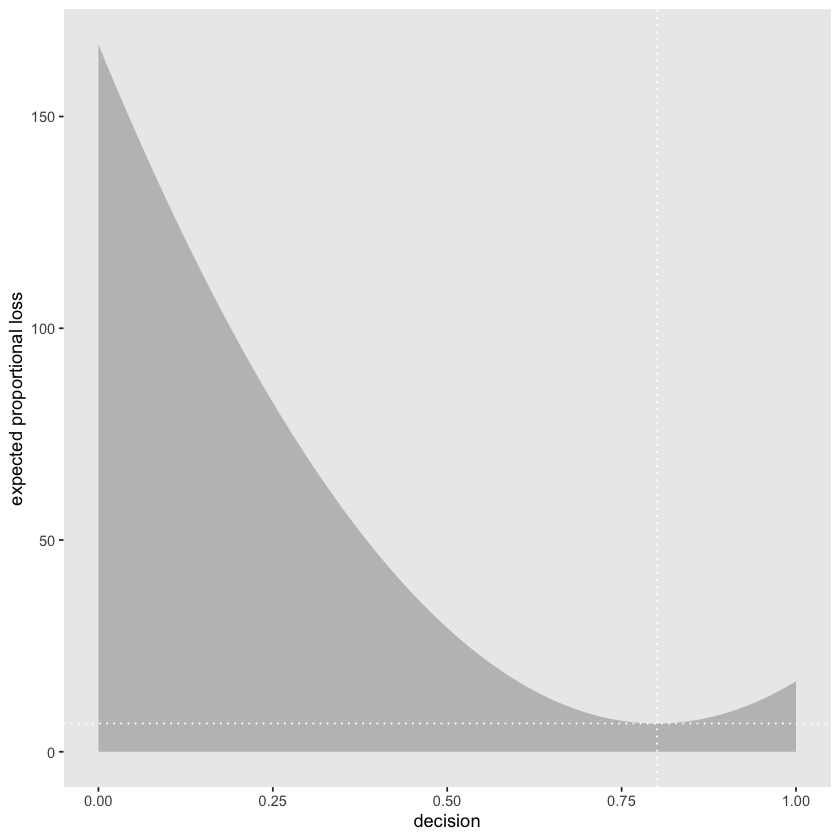

In [179]:
make_loss <- function(our_d){
  d %>% 
  mutate(loss = posterior * (our_d - p_grid)^2) %>% 
  summarise(weighted_average_loss = sum(loss))
}

# remake our `l` data
l <-
  d %>% 
  select(p_grid) %>% 
  rename(decision = p_grid) %>% 
  mutate(weighted_average_loss = purrr::map(decision, make_loss)) %>% 
  unnest()
# update to the new minimum loss coordinates
min_loss <-
  l %>% 
  filter(weighted_average_loss == min(weighted_average_loss)) %>% 
  as.numeric()

# update the plot
l %>%   
  ggplot(aes(x = decision)) +
  geom_ribbon(aes(ymin = 0, ymax = weighted_average_loss),
              fill = "grey75") +
  geom_vline(xintercept = min_loss[1], color = "white", linetype = 3) +
  geom_hline(yintercept = min_loss[2], color = "white", linetype = 3) +
  ylab("expected proportional loss") +
  theme(panel.grid = element_blank())

In [177]:
# 通过抽样预测
samples %>% 
  summarise(posterior_mean = mean(p_grid))

posterior_mean
<dbl>
0.8641975


# 虚拟数据

In [140]:
dummy_w <- rbinom( 1e6 , size=2 , prob=0.7 ) #假定投掷2次
table(dummy_w)/1e6

dummy_w
       0        1        2 
0.090555 0.419232 0.490213 

dummy_w
       0        1        2        3        4        5        6        7 
0.000026 0.000383 0.003969 0.020974 0.073648 0.171207 0.267492 0.266498 
       8        9 
0.155403 0.040400 

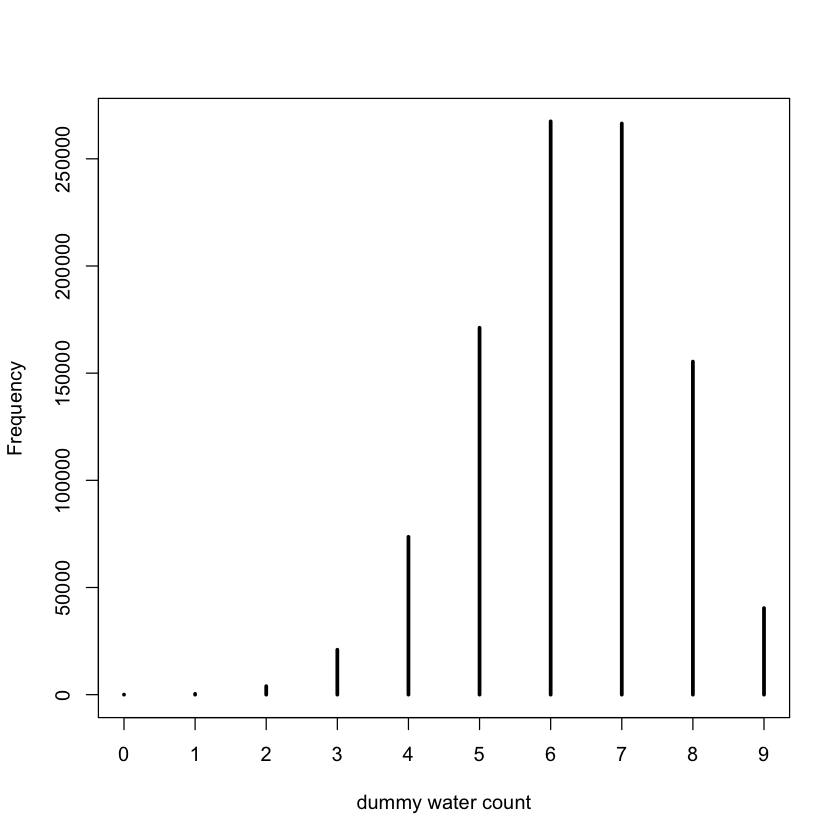

In [145]:
dummy_w <- rbinom(1e6, size=9, prob=0.7) #投9次
table(dummy_w)/1e6
simplehist(dummy_w , xlab="dummy water count" )

In [180]:
tibble(n           = 2,
       probability = .7,
       w           = 0:2) %>% 
  mutate(density   = dbinom(w, size = n, prob = probability))

n,probability,w,density
<dbl>,<dbl>,<int>,<dbl>
2,0.7,0,0.09
2,0.7,1,0.42
2,0.7,2,0.49


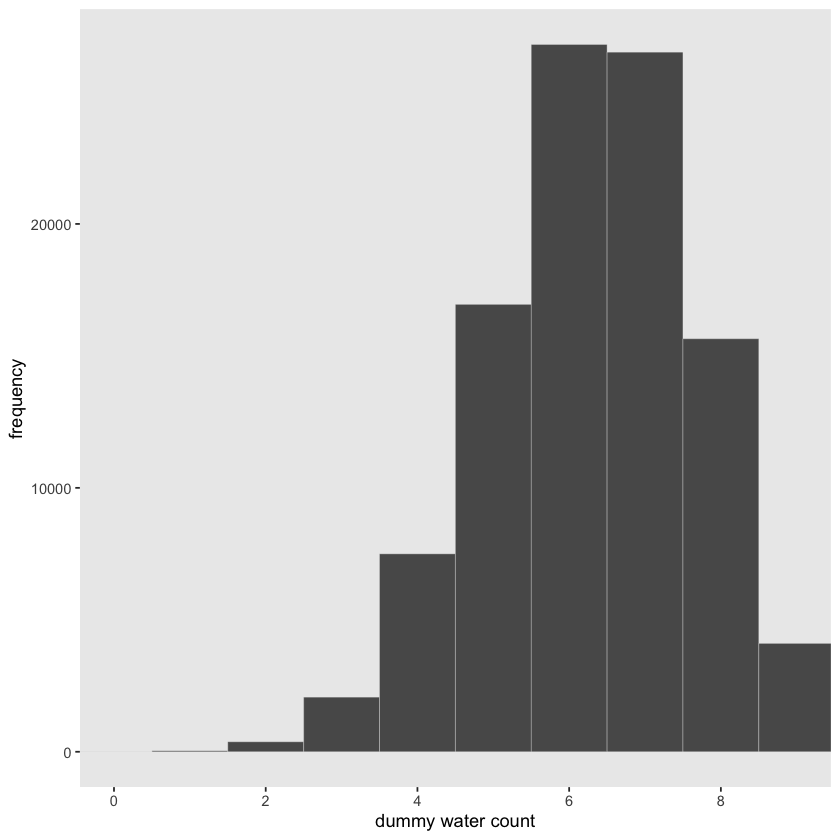

In [182]:
set.seed(3)
d <- tibble(draws = rbinom(1e5, size = 9, prob = .7))

# the histogram
d %>% 
  ggplot(aes(x = draws)) +
  geom_histogram(binwidth = 1, center = 0,
                 color = "grey92", size = 1/10) +
  scale_x_continuous("dummy water count",
                     breaks = seq(from = 0, to = 9, by = 2)) +
  ylab("frequency") +
  coord_cartesian(xlim = 0:9) +
  theme(panel.grid = element_blank())

### 模拟9个条件

In [184]:
simulate_binom <- function(n, probability){
  set.seed(3)
  rbinom(1e5, size = n, prob = probability) 
}

d <-
  tibble(n = c(3, 6, 9)) %>% 
  expand(n, probability = c(.3, .6, .9)) %>% 
  mutate(draws       = map2(n, probability, simulate_binom)) %>% 
  ungroup() %>% 
  mutate(n           = str_c("n = ", n),
         probability = str_c("p = ", probability)) %>% 
  unnest()

head(d)

Warning message:
“`cols` is now required.
Please use `cols = c(draws)`”


n,probability,draws
<chr>,<chr>,<int>
n = 3,p = 0.3,0
n = 3,p = 0.3,2
n = 3,p = 0.3,1
n = 3,p = 0.3,0
n = 3,p = 0.3,1
n = 3,p = 0.3,1


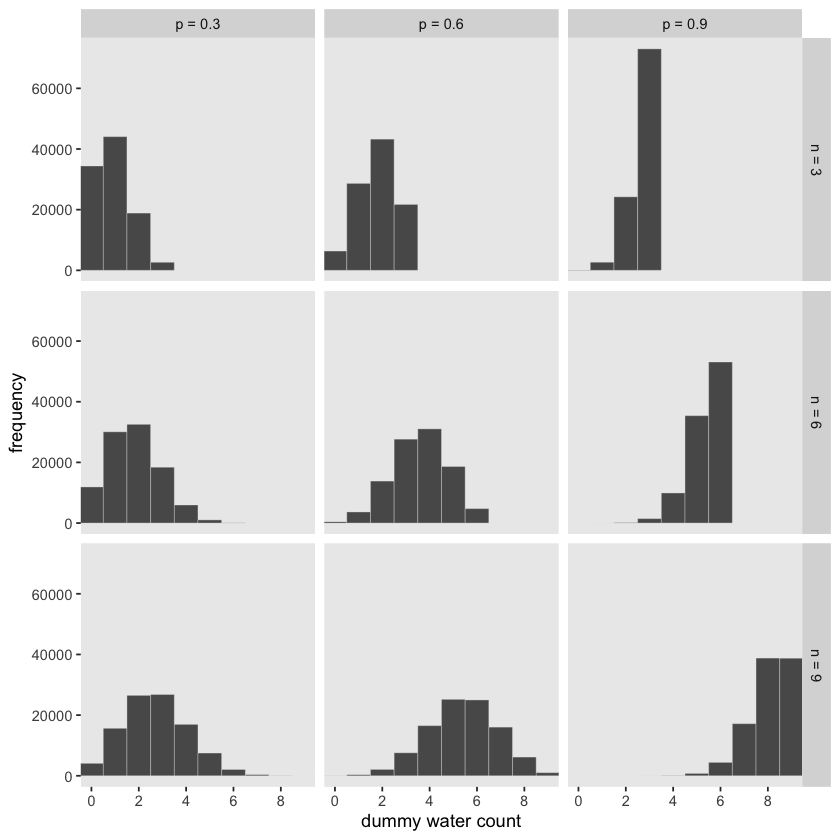

In [186]:
d %>% 
  ggplot(aes(x = draws)) +
  geom_histogram(binwidth = 1, center = 0,
                 color = "grey92", size = 1/10) +
  scale_x_continuous("dummy water count",
                     breaks = seq(from = 0, to = 9, by = 2)) +
  ylab("frequency") +
  coord_cartesian(xlim = 0:9) +
  theme(panel.grid = element_blank()) +
  facet_grid(n ~ probability)

## 模型检查

In [188]:
n <- 1001
n_success <- 6
n_trials  <- 9


d <-
tibble(p_grid     = seq(from = 0, to = 1, length.out = n),
     # note we're still using a flat uniform prior
     prior      = 1) %>% 
mutate(likelihood = dbinom(n_success, size = n_trials, prob = p_grid)) %>% 
mutate(posterior  = (likelihood * prior) / sum(likelihood * prior))

head(d)

p_grid,prior,likelihood,posterior
<dbl>,<dbl>,<dbl>,<dbl>
0.000,1,0.000000e+00,0.000000e+00
0.001,1,8.374825e-17,8.374825e-19
0.002,1,5.343808e-15,5.343808e-17
0.003,1,6.068653e-14,6.068653e-16
0.004,1,3.399517e-13,3.399517e-15
0.005,1,1.292911e-12,1.292911e-14


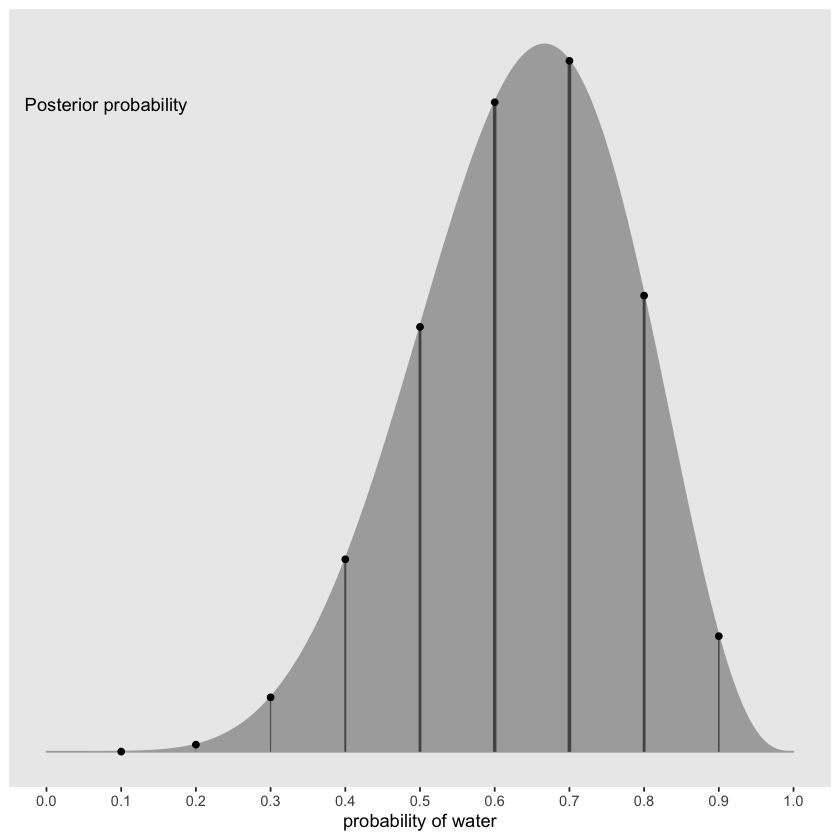

In [189]:
d %>% 
  ggplot(aes(x = p_grid)) +
  geom_ribbon(aes(ymin = 0, ymax = posterior),
              color = "grey67", fill = "grey67") +
  geom_segment(data = . %>% 
                 filter(p_grid %in% c(seq(from = .1, to = .9, by = .1), 3 / 10)),
               aes(xend = p_grid,
                   y = 0, yend = posterior, size = posterior),
               color = "grey33", show.legend = F) +
  geom_point(data = . %>%
               filter(p_grid %in% c(seq(from = .1, to = .9, by = .1), 3 / 10)),
             aes(y = posterior)) +
  annotate(geom = "text", 
           x = .08, y = .0025,
           label = "Posterior probability") +
  scale_size_continuous(range = c(0, 1)) +
  scale_x_continuous("probability of water", breaks = c(0:10) / 10) +
  scale_y_continuous(NULL, breaks = NULL) +
  theme(panel.grid = element_blank())

In [190]:
simulate_binom <- function(probability){
  set.seed(3)
  rbinom(1e5, size = 9, prob = probability) 
}

d_small <-
  tibble(probability = seq(from = .1, to = .9, by = .1)) %>% 
  mutate(draws       = purrr::map(probability, simulate_binom)) %>% 
  unnest(draws) %>% 
  mutate(label       = str_c("p = ", probability))

head(d_small)

probability,draws,label
<dbl>,<int>,<chr>
0.1,0,p = 0.1
0.1,2,p = 0.1
0.1,0,p = 0.1
0.1,0,p = 0.1
0.1,1,p = 0.1
0.1,1,p = 0.1


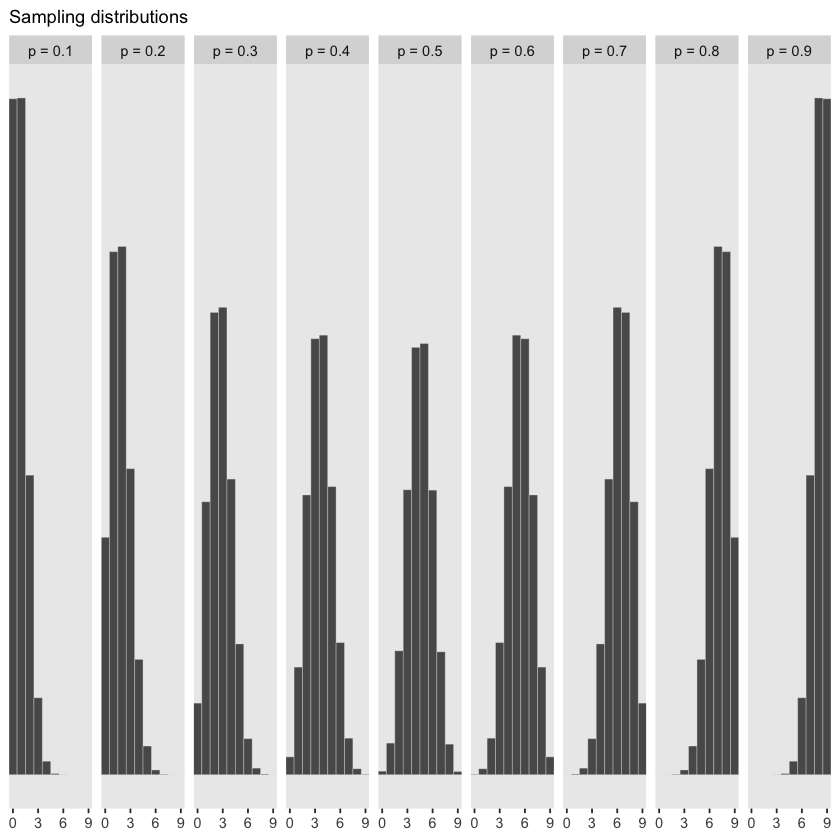

In [191]:
d_small %>%
  ggplot(aes(x = draws)) +
  geom_histogram(binwidth = 1, center = 0,
                 color = "grey92", size = 1/10) +
  scale_x_continuous(NULL, breaks = seq(from = 0, to = 9, by = 3)) +
  scale_y_continuous(NULL, breaks = NULL) +
  labs(subtitle = "Sampling distributions") +
  coord_cartesian(xlim = 0:9) +
  theme(panel.grid = element_blank()) +
  facet_wrap(~ label, ncol = 9) 

In [192]:
samples <-
  d %>% 
  sample_n(size = 1e5, weight = posterior, replace = T) %>% 
  mutate(w = purrr::map_dbl(p_grid, rbinom, n = 1, size = 9))

glimpse(samples)

Observations: 100,000
Variables: 5
$ p_grid     <dbl> 0.672, 0.569, 0.435, 0.650, 0.742, 0.520, 0.540, 0.705, 0…
$ prior      <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ likelihood <dbl> 0.27297097, 0.22823629, 0.10265029, 0.27162113, 0.2407475…
$ posterior  <dbl> 0.0027297097, 0.0022823629, 0.0010265029, 0.0027162113, 0…
$ w          <dbl> 3, 6, 5, 4, 7, 3, 5, 8, 8, 4, 8, 7, 4, 4, 4, 7, 6, 8, 6, …


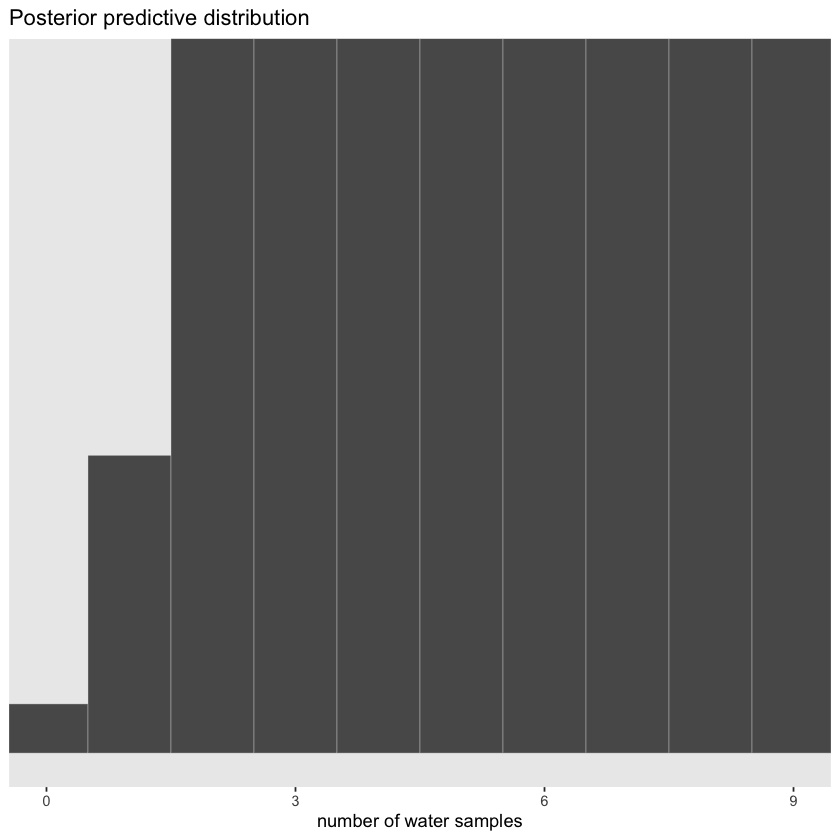

In [195]:
samples %>% 
  ggplot(aes(x = w)) +
  geom_histogram(binwidth = 1, center = 0,
                 color = "grey92", size = 1/10) +
  scale_x_continuous("number of water samples",
                     breaks = seq(from = 0, to = 9, by = 3)) +
  scale_y_continuous(NULL, breaks = NULL) +
  ggtitle("Posterior predictive distribution") +
  coord_cartesian(xlim = 0:9,
                  ylim = 0:3000) +
  theme(panel.grid = element_blank())

In [163]:
rbinom(1e4 , size=9 , prob=samples$posterior)

[1] 4 8 7 3 8 9 4 9 9 2 8 9 3 8 9 5 9 6 4 8 6 2 8 8 3 7 7 4 8 8 1 8 7 2 9 9
   [37] 1 8 5 5 9 8 2 9 8 2 8 7 5 8 6 4 8 8 3 8 8 5 8 4 3 9 6 4 9 8 4 8 7 3 9 7
   [73] 4 9 6 4 9 7 3 9 8 1 9 7 5 9 5 6 9 6 3 9 5 3 9 6 3 9 8 3 9 7 5 8 9 3 8 7
  [109] 2 9 7 3 7 8 5 7 9 2 8 9 4 8 7 5 9 8 1 8 7 3 7 5 2 8 8 1 8 5 3 9 6 4 8 5
  [145] 3 8 6 2 8 8 4 8 8 3 9 8 2 9 7 1 7 6 6 9 5 5 9 6 2 8 8 2 8 8 3 8 7 5 7 6
  [181] 2 9 8 3 9 6 5 8 7 3 9 6 3 7 6 2 8 8 3 9 3 3 8 6 2 9 8 3 9 7 3 8 6 4 9 7
  [217] 4 9 8 2 8 7 2 8 5 4 9 6 4 9 7 1 8 8 6 9 6 5 8 8 4 8 6 2 9 8 2 8 9 1 7 9
  [253] 3 9 8 2 7 8 2 9 7 1 7 6 5 9 7 4 8 7 5 7 6 1 7 5 4 8 5 4 9 8 2 9 7 3 8 5
  [289] 3 9 8 2 8 8 5 8 7 2 8 3 4 7 8 1 9 5 2 8 9 1 7 8 3 8 7 3 6 6 3 9 7 3 8 5
  [325] 5 7 5 2 9 9 4 8 8 5 8 7 2 8 8 3 9 8 4 8 7 4 7 7 3 9 9 2 8 5 4 7 6 3 8 5
  [361] 3 9 8 2 9 8 3 9 7 5 8 7 2 9 7 4 8 8 3 8 6 2 9 3 4 8 7 3 9 8 2 8 6 5 8 7
  [397] 4 5 8 3 7 7 2 9 5 3 8 5 4 8 7 3 8 7 3 8 6 4 7 7 3 9 5 2 9 7 3 9 6 3 6 9
  [433] 3 7 8 4 8 7 4 9 8 2 9 8 4 8 8 4 7 8 1 9 7 5 8 6 2 8 9 4 9 8 3 8 8 6 9 7
  [469] 3 8 7 3 8 8 4 7 7 2 8 8 3 8 9 4 8 7 0 8 7 3 8 9 4 7 7 8 8 7 4 9 7 4 8 7
  [505] 1 8 7 3 9 7 3 6 7 2 8 6 3 7 9 5 9 9 3 9 5 4 9 8 4 8 7 3 8 7 2 8 6 1 9 5
  [541] 1 8 7 4 9 6 2 9 8 3 8 8 2 9 7 1 9 6 2 9 7 7 8 6 2 8 9 1 7 8 2 8 4 0 8 5
  [577] 2 8 8 3 7 5 3 9 6 2 9 7 5 9 7 5 7 7 6 7 7 3 8 8 5 7 6 3 9 4 3 9 5 4 9 8
  [613] 2 8 7 1 9 8 0 7 7 4 9 7 1 8 6 5 8 6 3 8 7 4 7 6 4 9 6 2 8 8 4 6 8 3 7 8
  [649] 5 8 5 4 8 6 6 8 9 3 8 7 3 9 7 4 7 5 1 8 7 2 9 7 1 7 9 2 7 7 4 8 8 3 7 7
  [685] 1 9 7 4 8 6 5 8 6 3 8 7 5 8 7 2 8 7 5 6 9 3 9 7 1 8 5 4 8 5 3 8 6 3 9 5
  [721] 3 9 9 0 7 6 4 8 5 4 9 6 3 6 6 3 7 5 3 5 9 2 9 7 3 9 7 2 9 9 4 8 5 6 9 6
  [757] 4 8 9 5 9 9 4 8 6 2 8 6 3 9 7 2 7 7 4 9 8 1 8 7 4 9 7 1 8 9 4 9 6 1 9 7
  [793] 3 8 7 3 9 8 4 9 5 2 8 7 3 9 5 3 7 8 2 8 8 5 8 7 6 7 8 2 9 7 3 8 8 3 8 5
  [829] 3 8 5 4 7 7 2 9 7 5 7 7 2 8 8 5 9 8 2 9 6 4 8 7 1 7 7 2 8 7 2 8 6 4 9 8
  [865] 5 9 6 5 8 6 5 9 6 3 9 5 3 8 7 4 9 7 2 9 7 2 8 6 3 9 8 4 8 4 4 8 9 1 7 6
  [901] 4 6 7 3 7 5 2 9 5 4 7 7 5 8 7 5 8 8 6 8 7 3 9 6 4 8 5 2 7 7 2 8 6 3 8 8
  [937] 4 8 9 4 7 4 3 8 9 5 8 7 4 9 8 4 9 6 3 8 6 3 9 6 4 8 9 5 9 7 5 9 7 3 7 6
  [973] 4 9 9 4 9 8 4 8 9 1 9 6 4 6 9 4 7 7 3 8 7 5 8 7 4 9 8 5 8 7 7 8 8 3 7 7
 [1009] 3 8 7 4 8 6 3 8 5 3 9 8 6 8 7 4 8 4 4 6 7 4 6 4 5 8 8 4 8 7 5 8 9 3 9 7
 [1045] 5 8 6 3 7 6 0 7 9 5 8 7 3 8 6 5 9 6 2 8 6 1 8 9 5 8 8 3 9 6 3 9 8 4 8 7
 [1081] 2 8 7 4 9 8 4 9 8 2 9 5 3 9 6 2 8 7 1 9 7 3 9 6 2 8 6 1 8 6 3 8 9 4 7 8
 [1117] 5 8 9 3 8 5 6 8 5 3 8 7 3 8 8 2 9 6 4 8 9 3 9 7 8 9 7 3 7 6 3 9 6 0 7 7
 [1153] 3 7 5 5 9 7 3 8 7 1 9 7 3 6 7 5 9 8 4 9 5 4 6 6 2 8 7 4 9 7 2 9 7 3 7 8
 [1189] 1 9 3 5 7 9 4 8 8 3 9 5 2 7 7 5 9 9 5 8 7 4 8 7 1 9 8 5 8 7 3 9 6 5 8 4
 [1225] 4 9 7 3 9 8 4 9 8 3 7 8 4 8 9 3 5 8 1 8 7 1 9 9 4 9 7 6 8 7 0 9 5 1 9 8
 [1261] 2 9 6 4 7 7 6 8 5 4 9 7 6 9 6 4 9 8 6 7 8 2 9 7 5 8 8 5 9 9 1 8 8 2 8 8
 [1297] 3 9 7 3 8 8 5 9 8 5 8 6 6 9 9 3 8 7 1 8 6 4 8 6 3 8 6 3 7 6 1 8 8 3 8 5
 [1333] 3 6 5 6 9 8 4 9 8 3 9 4 1 8 7 5 9 7 3 7 7 3 8 8 3 9 8 4 9 7 3 9 8 4 8 7
 [1369] 6 7 7 5 8 8 2 8 5 4 7 6 1 8 6 4 9 8 1 7 5 4 9 5 3 8 8 2 9 8 5 8 7 4 8 5
 [1405] 1 8 7 3 8 7 3 8 7 3 9 7 3 9 7 2 9 8 4 9 5 4 7 7 5 9 7 3 9 5 4 8 4 5 7 7
 [1441] 3 9 8 2 8 9 4 9 6 5 8 8 5 7 6 1 9 6 2 9 5 6 8 8 4 9 5 4 9 8 5 8 7 4 7 8
 [1477] 0 7 8 2 9 7 1 9 6 3 9 7 4 7 7 4 8 8 3 8 6 2 7 5 3 7 8 2 9 6 3 8 6 5 9 7
 [1513] 4 8 8 3 9 7 5 9 5 1 9 6 4 8 7 2 7 9 4 8 7 3 8 4 4 9 7 2 8 7 2 8 8 6 8 7
 [1549] 5 8 7 3 9 7 2 9 7 5 9 7 3 9 6 6 9 7 5 9 6 3 8 8 3 7 5 3 9 8 4 9 8 4 8 5
 [1585] 3 8 6 2 9 8 5 9 8 1 8 7 2 8 5 5 7 8 2 7 8 1 9 8 2 9 7 3 9 6 6 8 8 4 9 7
 [1621] 4 8 7 5 8 7 4 6 8 1 6 6 3 9 5 2 8 7 5 8 7 5 8 3 4 9 7 1 9 6 1 9 9 2 8 8
 [1657] 3 9 7 8 9 6 4 8 9 4 8 5 4 9 8 4 8 7 1 7 6 5 8 5 3 8 6 2 9 8 5 8 6 3 8 8
 [1693] 4 8 8 3 6 8 4 9 6 2 7 8 5 9 8 4 8 7 3 7 7 4 8 9 4 7 6 4 8 7 7 9 9 3 9 9
 [1729] 1 7 6 1 8 6 4 9 7 3 7 7 3 7 9 4 9 8 5 9 8 3 9 5 3 9 7 2 8 8 1 8 7 2 7 5
 [1765] 4 7 9 3 8 8 5 9 5 3 8 7 5 9 7 1 8 5 5 8 8 2 9 8 5 7 8 1 8 7 5 9 8 4 9 7
 [18

# brms

In [193]:
library(brms)

In [194]:
b3.1 <-
  brm(data = list(w = 6), 
      family = binomial(link = "identity"),
      w | trials(9) ~ 1,
      # this is a flat prior
      prior(beta(1, 1), class = Intercept),
      seed = 3,
      control = list(adapt_delta = .999))

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL 'bd03edf50c00b88a7062d4f9d6dc27c4' NOW (CHAIN 1).
Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: beta_lpdf: Random variable is -1.15429, but must be >= 0!  (in 'model6825c27834c_bd03edf50c00b88a7062d4f9d6dc27c4' at line 22)

Chain 1: 
Chain 1: Gradient evaluation took 2.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Itera

Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.999 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [196]:
posterior_summary(b3.1)["b_Intercept", ] %>% 
  round(digits = 2)

Estimate Est.Error      Q2.5     Q97.5 
     0.64      0.14      0.36      0.88

In [197]:
f <-
  fitted(b3.1, summary = F,
         scale = "linear") %>% 
  as_tibble() %>% 
  set_names("p")

glimpse(f)

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”


Observations: 4,000
Variables: 1
$ p <dbl> 0.6920484, 0.5559454, 0.6096088, 0.5305334, 0.4819733, 0.6724561, …


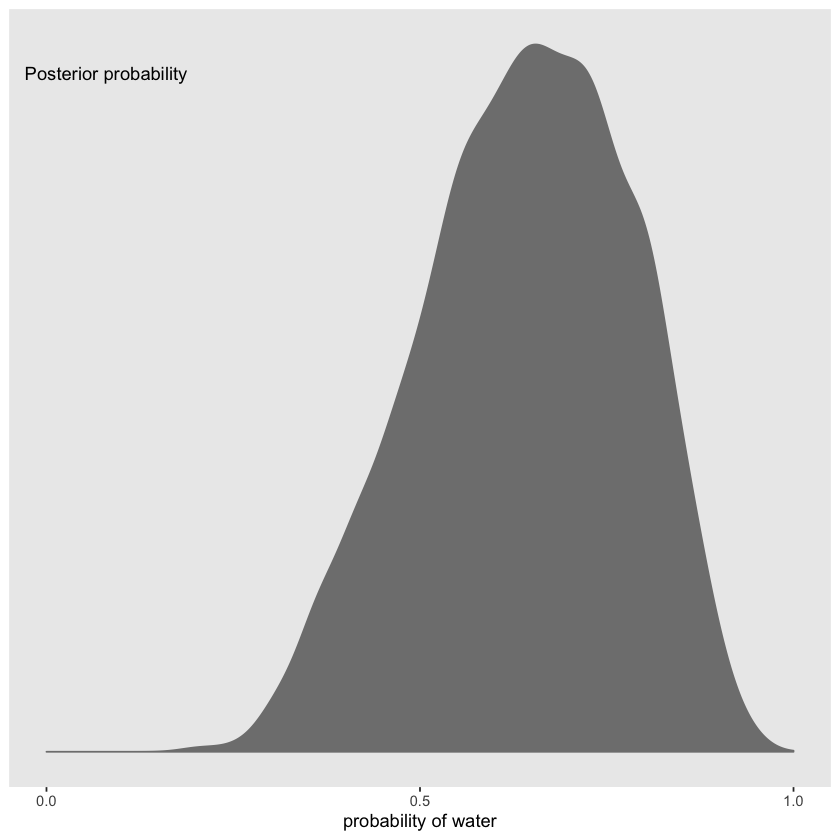

In [198]:
f %>% 
  ggplot(aes(x = p)) +
  geom_density(fill = "grey50", color = "grey50") +
  annotate(geom = "text", 
           x = .08, y = 2.5,
           label = "Posterior probability") +
  scale_x_continuous("probability of water",
                     breaks = c(0, .5, 1),
                     limits = 0:1) +
  scale_y_continuous(NULL, breaks = NULL) +
  theme(panel.grid = element_blank())

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


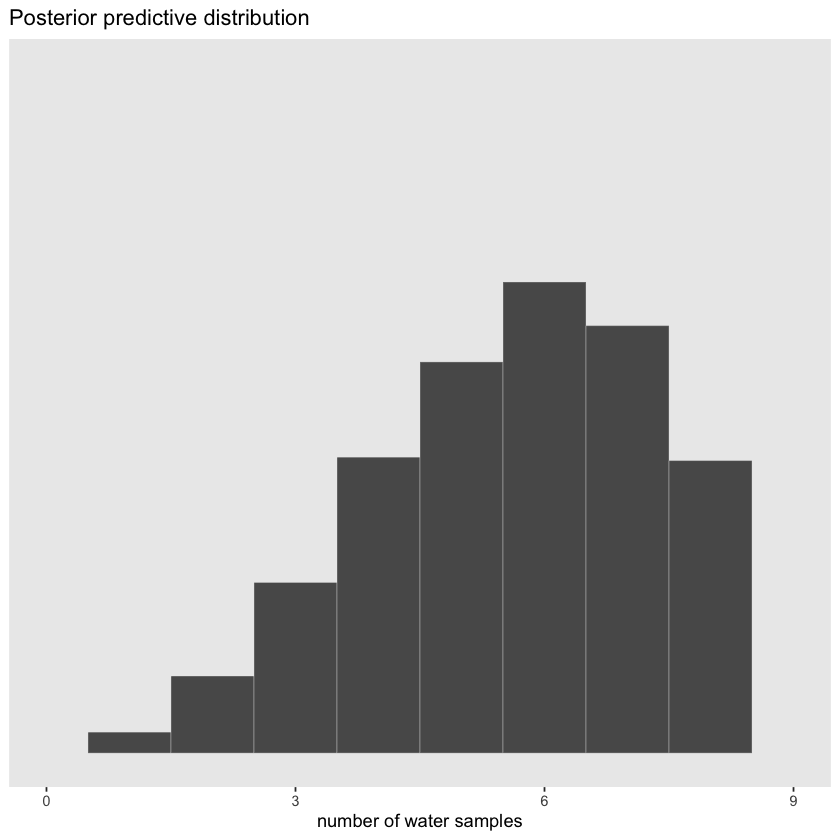

In [199]:
# the simulation
set.seed(3)

f <-
  f %>% 
  mutate(w = rbinom(n(), size = n_trials,  prob = p))

# the plot
f %>% 
  ggplot(aes(x = w)) +
  geom_histogram(binwidth = 1, center = 0,
                 color = "grey92", size = 1/10) +
  scale_x_continuous("number of water samples",
                     breaks = seq(from = 0, to = 9, by = 3), limits = c(0, 9)) +
  scale_y_continuous(NULL, breaks = NULL, limits = c(0, 1200)) +
  ggtitle("Posterior predictive distribution") +
  theme(panel.grid = element_blank())

In [169]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Catalina 10.15.3

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

locale:
[1] zh_CN.UTF-8/zh_CN.UTF-8/zh_CN.UTF-8/C/zh_CN.UTF-8/zh_CN.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] tidybayes_2.0.1      brms_2.11.1          Rcpp_1.0.3          
 [4] forcats_0.4.0        stringr_1.4.0        dplyr_0.8.4         
 [7] purrr_0.3.3          readr_1.3.1          tidyr_1.0.2         
[10] tibble_2.1.3         tidyverse_1.3.0      rethinking_1.95     
[13] dagitty_0.2-2        rstan_2.19.3         ggplot2_3.2.1       
[16] StanHeaders_2.21.0-1 repr_1.1.0          

loaded via a namespace (and not attached):
  [1] colorspace_1.4-1     ggridges_0.5.2       r